# Kaggle Titanic

## ライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
import pydotplus
import pydot
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from graphviz import *
from IPython import display
# from graphviz import Digraph
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.linear_model import ElasticNet
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## データの処理

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
df = pd.concat([train, test], axis=0, sort=False)

In [3]:
# 家族の人数 Family Size
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# 家族構成
df['Family_1_234_5'] = 0
df.loc[df['FamilySize'] ==1, 'Family_1_234_5']  = 0
df.loc[(df['FamilySize'] >=2) & (df['FamilySize'] <=4), 'Family_1_234_5']  = 2
df.loc[df['FamilySize'] >=5, 'Family_1_234_5']  = 3

# 敬称 Title
df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.',expand=False)
# Cabinの1文字目を抽出
df['Cabin_init'] = df['Cabin'].str[:1]
df['Cabin_init'] = df['Cabin_init'].fillna('U')

# Ticketの出現回数順になるのでreset_index。testも振り直しになるので分割後reset_index
ticket = pd.DataFrame(df['Ticket'].value_counts(sort=False),index=None)
ticket = ticket.reset_index().rename(columns={'Ticket':'Ticket_cnt','index':'Ticket'})
df = pd.merge(df,ticket, on='Ticket').sort_values('PassengerId').reset_index(drop=True)

# 1人かどうか IsAlone
df['IsAlone'] = 0
df.loc[df['FamilySize'] >=2, 'IsAlone']  = 1

# Fareを25ずつに区分け
df['Fare_bin'] = pd.cut(df['Fare'],
                        [x for x in range(int(df['Fare'].min()),int(df['Fare'].max()),25)],
                        right=False)

# Ageを5ずつに区分け
df['Age_bin'] = pd.cut(df['Age'],
                        [x for x in range(int(df['Age'].min()),int(df['Age'].max()),5)],
                        right=False)

# Passenger Idを2分割
# df['PassengerId_split'] = [0 if x<df['PassengerId'].mean() else 1 for x in df['PassengerId']] 

# Fareの欠損値に中央値を代入
# df['Fare'] = df['Fare'].fillna(df['Fare'].median())

# Fareの外れ値を99%内に
# df['Fare'] = scipy.stats.mstats.winsorize(df["Fare"], limits=[0.01, 0.01])

# Ticketの重複ありを1,それ以外を0にマッピング
# df['Ticket'] = df['Ticket'].duplicated()*1
# df['Fare'] = pd.qcut(df['Fare'],10)

# Cabinの重複ありを1,それ以外を0にマッピング
# df['Cabin'] = df['Cabin'].duplicated()*1

### 欠損値の補完

In [4]:
df.loc[(df["Title"].values == 'Mr'  ) & (df["Pclass"].values == 1  ) & (df["Age"].isnull()), "Age"] = df.query("Title == 'Mr' & Pclass == 1")["Age"].median()
df.loc[(df["Title"].values == 'Mr'  ) & (df["Pclass"].values == 2  ) & (df["Age"].isnull()), "Age"] = df.query("Title == 'Mr' & Pclass == 2")["Age"].median()
df.loc[(df["Title"].values == 'Mr'  ) & (df["Pclass"].values == 3  ) & (df["Age"].isnull()), "Age"] = df.query("Title == 'Mr' & Pclass == 3")["Age"].median()
df.loc[(df["Title"].values == 'Mrs'  ) & (df["Pclass"].values == 1  ) & (df["Age"].isnull()), "Age"] = df.query("Title == 'Mrs' & Pclass == 1")["Age"].median()
df.loc[(df["Title"].values == 'Mrs'  ) & (df["Pclass"].values == 2  ) & (df["Age"].isnull()), "Age"] = df.query("Title == 'Mrs' & Pclass == 2")["Age"].median()
df.loc[(df["Title"].values == 'Mrs'  ) & (df["Pclass"].values == 3  ) & (df["Age"].isnull()), "Age"] = df.query("Title == 'Mrs' & Pclass == 3")["Age"].median()
df.loc[(df["Title"].values == 'Miss'  ) & (df["Pclass"].values == 1  ) & (df["Age"].isnull()), "Age"] = df.query("Title == 'Miss' & Pclass == 1")["Age"].median()
df.loc[(df["Title"].values == 'Miss'  ) & (df["Pclass"].values == 2  ) & (df["Age"].isnull()), "Age"] = df.query("Title == 'Miss' & Pclass == 2")["Age"].median()
df.loc[(df["Title"].values == 'Miss'  ) & (df["Pclass"].values == 3  ) & (df["Age"].isnull()), "Age"] = df.query("Title == 'Miss' & Pclass == 3")["Age"].median()

df.loc[(df["Title"].values == 'Ms'      ) & (df["Age"].isnull()), "Age"] = df.query("Title == 'Ms'      ")["Age"].median()
df.loc[(df["Title"].values == 'Dr'      ) & (df["Age"].isnull()), "Age"] = df.query("Title == 'Dr' & Pclass == 1")["Age"].median()
df.loc[(df["Title"].values == 'Master'  ) & (df["Age"].isnull()), "Age"] = df.query("Title == 'Master' & Pclass == 3")["Age"].median()

df.loc[(df["Title"].values == 'Mr'  ) & (df["Pclass"].values == 3  ) & (df["Fare"].isnull()), "Fare"] = df.query("Title == 'Mr' & Pclass == 3")["Fare"].median()

In [5]:
le = LabelEncoder()
le.fit(df['Sex'])
df['Sex'] = le.transform(df['Sex'])
le.fit(df['Embarked'])
df['Embarked'] = le.transform(df['Embarked'])
le.fit(df['Cabin_init'])
df['Cabin_init'] = le.transform(df['Cabin_init'])
le.fit(df['Fare_bin'])
df['Fare_bin'] = le.transform(df['Fare_bin'])
le.fit(df['Age_bin'])
df['Age_bin'] = le.transform(df['Age_bin'])
le.fit(df['Title'])
df['Title'] = le.transform(df['Title'])

In [6]:
df.isnull().sum()

PassengerId          0
Survived           418
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin             1014
Embarked             0
FamilySize           0
Family_1_234_5       0
Title                0
Cabin_init           0
Ticket_cnt           0
IsAlone              0
Fare_bin             0
Age_bin              0
dtype: int64

In [7]:
df.drop([
         # 'PassengerId', 
         # 'Survived', 
         # 'Pclass', 
         'Name', 
         # 'Sex', 
         # 'Age', 
         # 'SibSp',
         # 'Parch', 
         'Ticket', 
         # 'Fare', 
         'Cabin', 
         # 'Embarked', 
         # 'FamilySize', 
         # 'Title',
         # 'Cabin_init',         
         # 'Ticket_cnt',
         'IsAlone',
         'Family_1_234_5',
         'Age_bin',
         'Fare_bin',
        ], axis=1, inplace=True)

In [8]:
df.tail()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Title,Cabin_init,Ticket_cnt
1304,1305,NaN,3,1,26.0,0,0,8.0500,2,1,13,8,1
1305,1306,NaN,1,0,39.0,0,0,108.9000,0,1,4,2,3
1306,1307,NaN,3,1,38.5,0,0,7.2500,2,1,13,8,1
1307,1308,NaN,3,1,26.0,0,0,8.0500,2,1,13,8,1
1308,1309,NaN,3,1,6.0,1,1,22.3583,0,3,9,8,3


## データの可視化

In [9]:
train = df.iloc[:len(train),:].copy()
train['Survived'] = train['Survived'].astype('int64')

In [10]:
test = df.iloc[len(train):,:].copy()
test.drop(['Survived'], axis=1, inplace=True)
test = test.reset_index(drop=True)

## モデルの学習・予測

In [11]:
X_train = train.drop(['Survived'], axis=1)
Y_train = train['Survived']

train_x, valid_x, train_y, valid_y = train_test_split(X_train, Y_train, test_size=0.33, random_state=0)

In [12]:
gbm = lgb.LGBMClassifier(
    objective='binary',
    max_depth=-1,   
    num_leaves=64,
    min_child_samples=20,

)

gbm = gbm.fit(train_x, train_y, eval_set = [(valid_x, valid_y)],
        categorical_feature=[
            'PassengerId', 
            # 'Survived', 
            'Pclass', 
            # 'Name', 
            'Sex', 
            # 'Age', 
            'SibSp',
            'Parch', 
            # 'Ticket', 
            # 'Fare', 
            # 'Cabin', 
            'Embarked', 
            # 'FamilySize',
            # 'Family_1_234_5',
            # 'IsAlone',
            'Title',
            'Cabin_init',
            # 'PassengerId_split', 
            'Ticket_cnt'
            # 'Fare_bin'
        ],
        early_stopping_rounds=20, verbose=10
       )

[10]	valid_0's binary_logloss: 0.445408
[20]	valid_0's binary_logloss: 0.395231
[30]	valid_0's binary_logloss: 0.384298
[40]	valid_0's binary_logloss: 0.376449
[50]	valid_0's binary_logloss: 0.377981


/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/estyle-085/opt/anaconda3/envs/Kenshu/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/estyle-085/opt/anaconda3/env

In [13]:
oof = gbm.predict(valid_x, num_iteration=gbm.best_iteration_)
print('score',round(accuracy_score(valid_y,oof)*100,2))

score 83.39


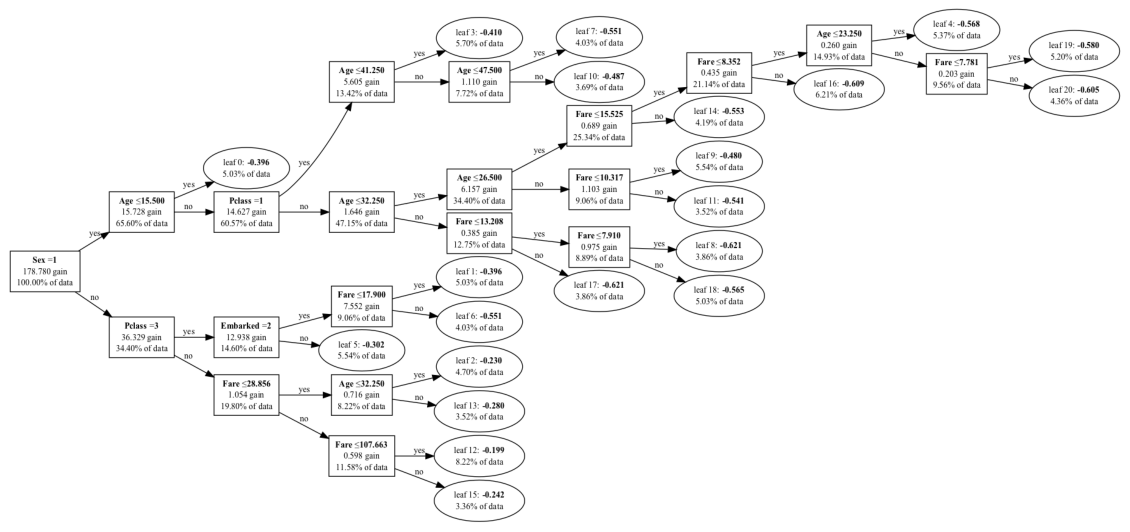

In [14]:
ax = lgb.plot_tree(gbm, tree_index=0, figsize=(20, 20), show_info=['data_percentage','split_gain'])
graph = lgb.create_tree_digraph(gbm, tree_index=0, format='png', name='Tree')

<AxesSubplot:>

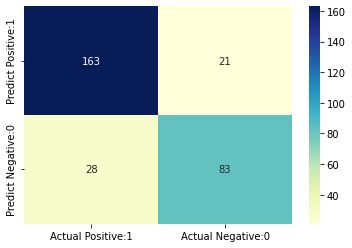

In [15]:
cm = confusion_matrix(valid_y, oof)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [16]:
pd.DataFrame({'特徴':X_train.columns,
             'importance':gbm.booster_.feature_importance(importance_type='gain')}).sort_values('importance',ascending=False)

,特徴,importance
2,Sex,969.995804
3,Age,570.042197
6,Fare,424.979620
1,Pclass,298.511323
8,FamilySize,111.166490
7,Embarked,92.766746
9,Title,57.439748
10,Cabin_init,14.403841
11,Ticket_cnt,7.642742
0,PassengerId,0.000000


In [17]:
test_pred = gbm.predict(test, num_iteration=gbm.best_iteration_)
test_pred = pd.DataFrame(test_pred,  columns=['Survived'])
submission = pd.DataFrame(test['PassengerId'])
submission = pd.concat([submission, test_pred], axis=1)

submission['Survived'].sum()/submission['Survived'].count()

0.361244019138756

In [18]:
submission.to_csv('output/submission.csv',index=False)